In [1]:
from matplotlib import pyplot as plt
from lira_funcs import *

In [2]:
# Sampling related parameters
### Depending on the shape, it may work with lower ADC frequencies
f_s_adc = 10e6 #5e5
f_mod = 1e3
n_reps = 1

t_s_mod = 1 / f_mod
n_points = f_s_adc // f_mod

print("N_points:\t", n_points)

### For using the full integral numerical result
#I_pd_func = I_pd_integral_trapz_func

### For using the integral of the band of interest
# I_pd_func =  I_pd_integral_bw_func

### For using the analytical short equation of the band of interest
I_pd_func = I_pd_analytical_func

# Method = 'same-norm' (normalitzation) good to reach edges; 'same-weighted' (only weighting factor by number of
# elements) not so good bu better than only same; 'same' (nor weighting nor normalized) has reduced range.
#method = "same-weighted"
method = "same"

# Optical design parameters
L_2 = 1e-3
L_1 = 2*L_2
delta_L_2_sensor = 0
# Baseline for 50K is 86mm
L_3 = 86e-3
# To add 20K margin (10k on each side) to reach 50K (theoretical: e_V*beta/(dT*f_mod*alpha_T))
###L_3 = 57e-3
lambda_1 = 1.5e-6
lambda_2 = 1.6e-6
# Aluminium CTE
alpha_T = 23.1e-6
# Temperature of the sensor with respect to the centered reference
T_sensor = 10
T_ref = 0
delta_T = T_sensor - T_ref
# PK4GA7P1
e_V = 100e-6 / 150
beta = 150 * f_mod

# Maximum power on the photodiode [W]
P_pd_max = 1e-6

# Photodiode responsivity [A/W]
res_pd = 1

# TIA gain [V/A]
tia_gain = 200e3

# FDA gain
fda_gain = 15
# ADC FSR [V]
adc_fsv = 2
# ADC #bits
adc_bits = 14

# in dB, set to None to disable
SNR_dB = 17

N_points:	 10000.0


Sensitivity:			 39.731999999999985  us/K
Carrier frequency:		 64.60097491666669  kHz
Sinc frequency:			 2.083902416666665  kHz
Relative phase between signals:	 149.03569947419967  degrees
Time delay between signals:	 198.65999999999994  us
Vpp:			 150.0  V
Maximum:	 8815.0


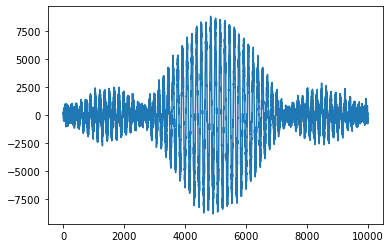

In [25]:
sensitivity_value = sensitivity(L_3=L_3, e_V=e_V, beta=beta)
print("Sensitivity:\t\t\t", sensitivity_value * 1e6, ' us/K')

analytic_carrier_freq = get_carrier_freq(lambda_1=lambda_1, lambda_2=lambda_2, e_V=e_V, beta=beta)
print("Carrier frequency:\t\t", analytic_carrier_freq * 1e-3, ' kHz')

analytic_sync_freq = get_sync_freq(lambda_1=lambda_1, lambda_2=lambda_2, e_V=e_V, beta=beta)
print("Sinc frequency:\t\t\t", analytic_sync_freq * 1e-3, ' kHz')

analytic_rel_phase = get_relative_T0_phase(L_3=L_3, alpha_T=alpha_T, delta_T=delta_T,
                                           lambda_1=lambda_1, lambda_2=lambda_2, )
print("Relative phase between signals:\t", analytic_rel_phase * 180 / np.pi, ' degrees')

analytical_delay = old_temp_to_delay(analytic_sync_freq, delta_T=delta_T, L_3=L_3,
                                 alpha_T=alpha_T, lambda_1=lambda_1, lambda_2=lambda_2)
print("Time delay between signals:\t", analytical_delay * 1e6, ' us')

V_mod, t_vec = V_mod_ramp_func(beta=beta, n_points=n_points, t_start=-t_s_mod / 2, t_end=t_s_mod / 2)
if n_reps > 1:
    V_mod = np.tile(V_mod, n_reps)
    t_vec = np.linspace(-n_reps * t_s_mod / 2, n_reps * t_s_mod / 2, int(n_reps * n_points))

plt.plot(t_vec, V_mod)
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.savefig("piezo_driver_ramp.png")
plt.close()
print("Vpp:\t\t\t", V_mod.max() - V_mod.min(), " V")

I_pd_Tref = I_pd_func(V_mod, L_1=L_1, L_2=L_2, L_3=L_3, lambda_1=lambda_1, lambda_2=lambda_2, e_V=e_V,
                      alpha_T=alpha_T, delta_T=T_ref, P_opt=P_pd_max)
I_pd_Tref = I_pd_Tref.astype(float)
#I_pd_Tsensor = I_pd_func(V_mod, L_1=L_1, L_2=L_2 + delta_L_2_sensor, L_3=L_3, lambda_1=lambda_1, lambda_2=lambda_2, e_V=e_V,
                         #alpha_T=alpha_T, delta_T=T_sensor, P_opt=P_pd_max)

if SNR_dB is not None:
    signal_std = I_pd_Tref.std()
    noise_std = signal_std / (10 ** (SNR_dB / 20))
    I_pd_Tref += np.random.normal(loc=0, scale=noise_std, size=I_pd_Tref.size)

    #signal_std = I_pd_Tsensor.std()
    #noise_std = signal_std / (10 ** (SNR_dB / 20))
    #I_pd_Tsensor += np.random.normal(loc=0, scale=noise_std, size=I_pd_Tsensor.size)

ylabel = "Photodiode current $[\mu A]$"
scale = 1e6

if res_pd is not None:
    I_pd_Tref *= res_pd
    #I_pd_Tsensor *= res_pd

    if tia_gain is not None:
        I_pd_Tref *= tia_gain
        #I_pd_Tsensor *= tia_gain
        ylabel = "TIA output voltage $[V]$"
        scale = 1

    if adc_bits is not None:
        # DC blocking
        I_pd_Tref -= I_pd_Tref.mean()
        #I_pd_Tsensor -= I_pd_Tsensor.mean()
        # FDA (or second stage) gain
        I_pd_Tref *= fda_gain
        #I_pd_Tsensor *= fda_gain
        # Quantization
        lsb = adc_fsv/((2**adc_bits) - 1)
        I_pd_Tref = np.round(I_pd_Tref/lsb)
        #I_pd_Tsensor = np.round(I_pd_Tsensor / lsb)
        ylabel = "ADC output [counts]"
        scale = 1

max = np.amax(I_pd_Tref)
print("Maximum:\t", max)

from scipy import signal
        
plt.plot(I_pd_Tref)


In [8]:
file = "noisy_signal.txt"
with open(file, "w") as f:
    for i in range(int(n_points)):
        f.write(str(I_pd_Tref[i]))
        f.write("\n")

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
from pylab import grid

In [40]:
b = np.array([-0.000241136446111969281885789584407575603,
-0.002063371900178733679004361434294878563,
-0.006567530896118588430721008109003378195,
-0.013358694459752039340738605233127600513,
-0.018712480292357211442144659940822748467,
-0.016736642680751659395532726648525567725,
-0.003982308590856747584907360248962504556,
 0.015091481567290373003165093734878610121,
 0.02741390042185312334033220338369574165, 
 0.019026569244288648458107715555343020242,
-0.011979658900086648243288323101296555251,
-0.047288145929299287006930541110705235042,
-0.054505848424721087264188668086717370898,
-0.007517122992580234364101698929516714998,
 0.09161605702685061969336999254664988257, 
 0.206406410069560342090966287287301383913,
 0.283310609942778013348174681595992296934,
 0.283310609942778013348174681595992296934,
 0.206406410069560342090966287287301383913,
 0.09161605702685061969336999254664988257, 
-0.007517122992580234364101698929516714998,
-0.054505848424721087264188668086717370898,
-0.047288145929299287006930541110705235042,
-0.011979658900086648243288323101296555251,
 0.019026569244288648458107715555343020242,
 0.02741390042185312334033220338369574165, 
 0.015091481567290373003165093734878610121,
-0.003982308590856747584907360248962504556,
-0.016736642680751659395532726648525567725,
-0.018712480292357211442144659940822748467,
-0.013358694459752039340738605233127600513,
-0.006567530896118588430721008109003378195,
-0.002063371900178733679004361434294878563,
-0.000241136446111969281885789584407575603])

In [ ]:
b = np.array([-0.001056292739773977444259211999622039002,
-0.006686630555778201936978355490737158107,
-0.01534758333444215250285225238258135505, 
-0.015087036617943137481456794546375022037,
-0.000258350047325561565318002843483213837,
 0.010596621959747240526716893782577244565,
 0.000584761428809683881345493627890164134,
-0.010614105441120451345238251406044582836,
 0.000805016668660975633943499563116574791,
 0.012315568680350065175477247692015225766,
-0.003140582156627534995974038167787512066,
-0.014799185627661819511513563440985308262,
 0.00672733797272536109684848426581993408, 
 0.017676780962737843883036958914090064354,
-0.012132612921616920884093637766909523634,
-0.02069827724490066675477883961775660282, 
 0.020234500556743917343283101217821240425,
 0.023628768006417371488891987496572255623,
-0.032733367106079221120484845641840365715,
-0.026211702387587611229324835449006059207,
 0.054000214273433801148716071338640176691,
 0.028241158674696925645619671740860212594,
-0.100065523991517940638473760373017285019,
-0.029531130876252652955882282981292519253,
 0.316265357787942513745349515374982729554,
 0.529991781472911815953352743235882371664,
 0.316265357787942513745349515374982729554,
-0.029531130876252652955882282981292519253,
-0.100065523991517940638473760373017285019,
 0.028241158674696925645619671740860212594,
 0.054000214273433801148716071338640176691,
-0.026211702387587611229324835449006059207,
-0.032733367106079221120484845641840365715,
 0.023628768006417371488891987496572255623,
 0.020234500556743917343283101217821240425,
-0.02069827724490066675477883961775660282,
-0.012132612921616920884093637766909523634,
 0.017676780962737843883036958914090064354,
 0.00672733797272536109684848426581993408, 
-0.014799185627661819511513563440985308262,
-0.003140582156627534995974038167787512066,
 0.012315568680350065175477247692015225766,
 0.000805016668660975633943499563116574791,
-0.010614105441120451345238251406044582836,
 0.000584761428809683881345493627890164134,
 0.010596621959747240526716893782577244565,
-0.000258350047325561565318002843483213837,
-0.015087036617943137481456794546375022037,
-0.01534758333444215250285225238258135505, 
-0.006686630555778201936978355490737158107,
-0.001056292739773977444259211999622039002])

5000


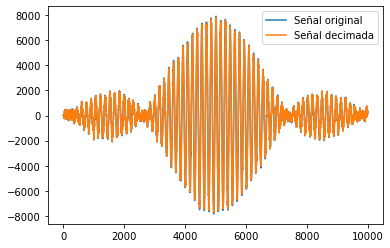

In [57]:
pct_points_to_keep = 0.5
# Calcular la longitud de la señal de salida
n_out = int(len(I_pd_Tref) * pct_points_to_keep)
# Calcular el factor de decimación necesario
q = len(I_pd_Tref) // n_out

y_prev = signal.lfilter(b, 1.0, I_pd_Tref)
y_prev_dec = signal.decimate(y_prev, q)
y = signal.lfilter(b, 1.0, y_prev_dec)

print(len(y))

# Definimos el eje x para ambas señales
t = [i for i in range(len(I_pd_Tref))]
t_half = [i for i in range(0, len(I_pd_Tref), q)]

# Graficamos la señal original y la decimada
plt.plot(t, y_prev, label='Señal original')
plt.plot(t_half, y_prev_dec, label='Señal decimada')
plt.legend()
plt.show()

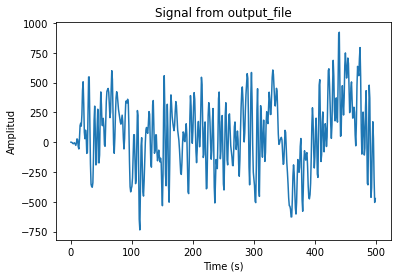

In [3]:
i = np.loadtxt('output_file.txt')

#diff = y - i

#file = "signal_filtered_py.txt"
#with open(file, "w") as f:
    #for j in range(int(len(y))):
        #f.write(str(y[int(j)]))
        #f.write("\n")

# Graficar señal de entrada y salida
#fig1, ax1 = plt.subplots()
#fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
#fig4, ax4 = plt.subplots()

#ax1.plot(I_pd_Tref)
#ax1.set_xlabel('Time (s)')
#ax1.set_ylabel('Amplitud')
#ax1.set_title('Noisy signal')

#ax2.plot(t-delay,y)
#ax2.plot(y, 'g')
#ax2.set_xlabel('Time (s)')
#ax2.set_ylabel('Amplitud')
#ax2.set_title('Software filtered signal')

ax3.plot(i)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitud')
ax3.set_title('Signal from output_file')

#ax4.plot(diff)
#ax4.set_xlabel('Time (s)')
#ax4.set_ylabel('Amplitud')
#ax4.set_title('Difference')

plt.show()

In [39]:
from pylab import grid

# Cálculo de la transformada de Fourier de la señal con ruido
I_pd_Tref_fft = np.fft.fft(I_pd_Tref)

# Cálculo del espectro de frecuencia
freq = np.fft.fftfreq(I_pd_Tref.size, d=1/fs)

# Visualización del espectro de frecuencia de la señal con ruido
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(np.abs(I_pd_Tref_fft)))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencia de la señal con ruido')
plt.show()

# Cálculo de la transformada de Fourier de la señal filtrada
y_fft = np.fft.fft(y)
i_fft = np.fft.fft(i)

# Cálculo del espectro de frecuencia
freq2 = np.fft.fftfreq(y.size, d=1/fs)
freq3 = np.fft.fftfreq(i.size, d=1/fs)

# Visualización del espectro de frecuencia de la señal filtrada
plt.plot(np.fft.fftshift(freq2), np.fft.fftshift(np.abs(y_fft)))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencia de la señal filtrada')
plt.show()


index_py = np.argmax(I_pd_Tref_fft)
index_vhd = np.argmax(y_fft)

print(index_py)
print(index_vhd)

#plt.plot(np.fft.fftshift(freq3), np.fft.fftshift(np.abs(i_fft)))
#plt.xlabel('Frecuencia (Hz)')
#plt.ylabel('Amplitud')
#plt.title('Espectro de frecuencia de la señal filtrada')
#plt.show()


66
2436
